## Import Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Add, Input
from keras.datasets import mnist

# Enable GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [3]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import kagglehub

# Download the latest version of the CelebA dataset
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# print("Path to dataset files:", path)
path = "/Users/yfahmy/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/"
base_dir = os.path.join(path, "img_align_celeba") 

# Image size to resize all images to
image_dim = 200
num_channels = 3
images = []

# Optional: limit number of images if needed
MAX_IMAGES = 10000

# Loop through images in the dataset directory
for i, filename in enumerate(os.listdir(base_dir)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(base_dir, filename)

        try:
            img = Image.open(image_path).convert("RGB")
            img = img.resize((image_dim, image_dim))
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

        if i + 1 >= MAX_IMAGES:
            break

# Convert list to numpy array
images = np.array(images)

# Split into training and testing sets
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Ensure the correct shape for TensorFlow (batch, height, width, channels)
x_train = x_train.reshape(len(x_train), image_dim, image_dim, num_channels)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, num_channels)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

/opt/homebrew/anaconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


x_train shape: (8000, 200, 200, 3), x_test shape: (2000, 200, 200, 3)


## Add Gaussian Noise

In [4]:
noise_factor = 0.075
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

## Add Salt and Pepper Noise

In [5]:
def add_s_and_p_noise_batch(images, salt_prob=0.01, pepper_prob=0.01):
    N, H, W, C = images.shape
    rand_matrix = np.random.rand(N, H, W)
    salt_mask = rand_matrix < salt_prob
    pepper_mask = rand_matrix > (1 - pepper_prob)
    images[salt_mask] = 255
    images[pepper_mask] = 0
    return images

x_train_noisy = add_s_and_p_noise_batch(x_train_noisy)
x_test_noisy = add_s_and_p_noise_batch(x_test_noisy)

In [6]:
# clip the values in the range of 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Exploratory Data Analysis

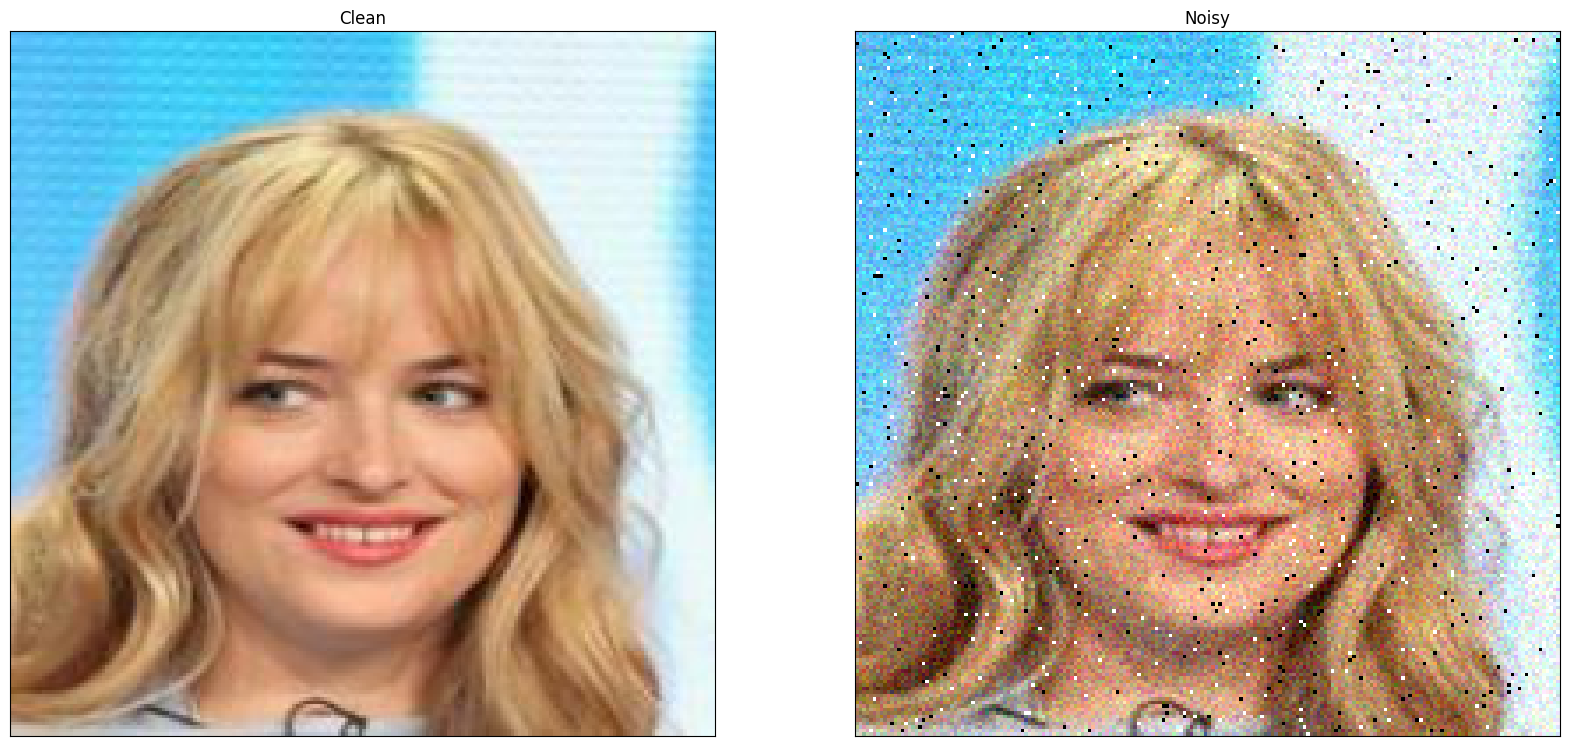

In [7]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 2, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
plt.show()

## Model Creation

In [8]:
input_img = Input(shape=(image_dim, image_dim, num_channels))  # RGB images

# First layer (Conv + ReLU)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

for _ in range(6): 
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Last layer (Conv, No Activation)
x = Conv2D(3, (3, 3), padding='same')(x)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, x])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss='mse')
model.summary()

2025-03-23 15:37:21.219046: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-03-23 15:37:21.219084: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-23 15:37:21.219096: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-03-23 15:37:21.219256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-23 15:37:21.219270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 200, 200,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 200,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_4[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_5[0][0]  

 Total params: 226,627 (885.26 KB)

 Trainable params: 225,859 (882.26 KB)

 Non-trainable params: 768 (3.00 KB)

## Train the model

In [9]:
model.fit(x_train_noisy, x_train, epochs=100 , batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))
model.save("celeba_cnn.keras")

Epoch 1/100


2025-03-23 15:37:48.422006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-23 15:37:48.429427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1098

2025-03-23 15:43:13.370667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


125/125 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - loss: 0.1092 - val_loss: 0.0123
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - loss: 0.0074 - val_loss: 0.0094
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - loss: 0.0046 - val_loss: 0.0063
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - loss: 0.0033 - val_loss: 0.0036
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - loss: 0.0026 - val_loss: 0.0028
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - loss: 0.0019 - val_loss: 0.0023
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - loss: 0.0017 - val_loss: 0.0021
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - loss: 0.0016 - val_loss: 0.0022
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 

## Visualize the Results

In [10]:
# predict the results from model (get compressed images)
pred = model.predict(x_test_noisy)

2025-03-24 00:43:26.305246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04802533..1.020793].


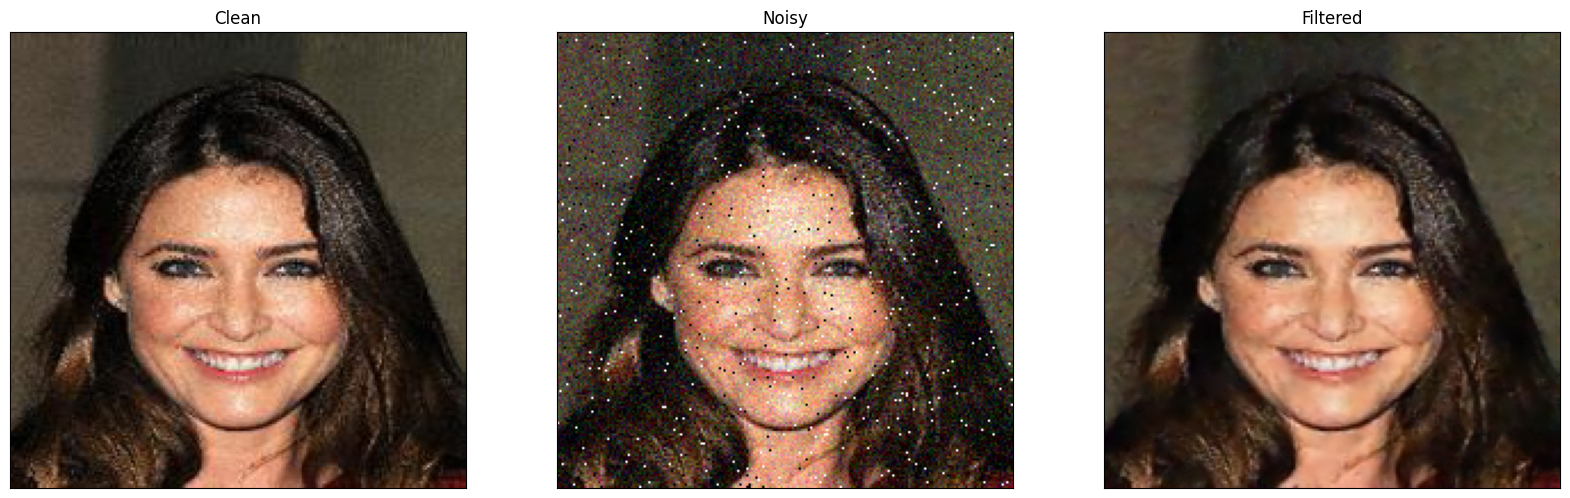

In [11]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 3, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
# display cleaned image
ax = plt.subplot(1, 3, 3)
plt.imshow(pred[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Filtered")
plt.show()